이 절에서 훈련하는 동안 모델 내부에서 일어나는 일을 조사하고 제어하는 방법을 살펴보겠습니다. 대규모 데이터셋에서 model.fit()이나 model.fit_generator()로 수십번의 에포크를실행하는 것은 종이 비행기를 날리는 것과 조금 비슷합니다. 일단 손을 떠나면 종이 비행기 경로와 착륙 지점을 제어할 방법이 없습니다. 나쁜 결과를 피하려면 (그래서 종이 비행기를 낭비하지 않으려면) 종이 비행기 대신 다른 것을 사용하는 것이 좋습니다. 드론은 주변 한경을 감지한 데이터를 조작부에 전달하여 현재 상태를 바탕으로 자동으로 운전합니다. 앞으로 소개할 기법은 model.fit() 호출을종이 비행기에서 스스로 판단하고 동적으로 결정하는 똑똑한 자동 드론으로 바꾸어 줄 것입니다.

## 콜백을 사용하여 모델의 훈련 과정 제어하기

모델을 훈련할 떄 미리 예상할 수 없는 것들이 많습니다. 특히 최적의 검증 손실을 얻기 위해 얼마나 많은 에포크가 필요한지 알지 못합니다. 지금까지 예제는 적적한 훈련 에포크를 알아내기 위해 첫 번째 실행에서 과대적합이 시작될 때까지 충분한 에포크로 훈련했습니다. 그런 다음 최적의 에포크 횟수로 처음부터 새로운 훈련을 시작했습니다. 당연히 이런 방식은 낭비가 많습니다.

더 좋은 처리 방법은 검증 손실이 더 이상 향상되지 않을 때 훈련을 멈추는 것입니다. 케라스의 콜백을 사용하여 구현할 수 있습니다. 콜백은 모델의 fit()메서드가 호출될 때 전달되는 객체(특정 메서드를 구현한 클래스 객체)입니다. 훈련하는 동안 모델은 여러 지점에서 콜백을 호출합니다. 콜백은 모델의 상태와 성능에 대한 모든 정보에 접근하고 훈련 중지, 모델 저장, 가중치 적재 또는 모델 상태 변경 등을 처리할 수 있습니다.

다음은 콜백을 사용하는 몇가지 사례입니다.

 * **모델 체크포인트 저장**: 훈련하는 동안어떤 지점에서 모델의 현재 가중치를 저장합니다.
 * **조기 종료**: 검증 손실이 더 이상 향상되지 않을 때 훈련을 중지합니다(물론 훈련하는 동안 얻은 가장 좋은 모델을 저장합니다).
 * **훈련하는 동안 하이퍼파라미터 값을 동적으로 조정합니다**: 옵티마이저의 학습률 같은 경우입니다.
 * **훈련과 검증 지표를 로그에 기록하거나 모델이 학습한 표현이 업데이트될 때마다 시각화합니다**: 앞서 보았던 케라스의 진행 표시줄이 하나의 콜백입니다!

keras.callbacks 모듈은 많은 내장 콜백을 포함하고 있습니다(다음은 전체 리스트가 아닙니다).

```
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger
```
콜백 사용법을 익히기 위해 ModelCheckpoint, EarlyStopping, ReduceLROnPlateau를 사용한 예를 살펴봅시다.


##ModelCheckpoint와 EarlyStopping 콜백

EarlyStopping 콜백을 사용하면 정해진 에포크 동안 모니터링 지표가 향상되지 않을 때 훈련을 중지할 수 있습니다. 예를 들어 과대적합이 시작되자마자 훈련을 중지할 수 있습니다. 따라서 에포크 횟수를 줄여 다시 모델을 훈련할 필요가 없습니다. 일반적으로 이 콜백은 훈련하는 동안 모델을 계속 저장해 주는 ModelCheckpoint와 함께 사용합니다. (선택적으로 지금까지 가장 좋은 모델만 저장할 수 있습니다. 에포크마지막에 다다랐을 때 최고 성능을 달성한 모델입니다.

In [ ]:
import keras 

callbacks_list = [ # fit() 메서드의 callbacks 매개변수를 사용하여 콜백의 리스트를 모델로 전달합니다. 몇 개의 콜백이라도 전달할 수 있습니다.
                  keras.callbacks.EarlyStopping(  #성능 향상이 멈추면 훈련을 중지합니다.
                      monitor = 'val_acc', #모델의 검증 정확도를 모니터링합니다.
                      patience = 1,   #1 에포크보다 더 길게( 즉 2에포크 동안) 정확도가 향상되지 않으면 훈련이 중지됩니다.
                  ),
                  keras.callbacks.ModelCheckpoint(  #에포크마다 현재 가중치를 저장합니다.
                      filepath = 'my_model.h5',   #모델 파일의 경로
                      #이 두 매개변수는 val_loss가 좋아지지 않으면 모델 파일을 덮어쓰지 않는다는 뜻입니다.
                      monitor = 'val_loss',  
                      save_best_only = True,
                  )
]

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])  #정확도를 모니터링하므로 모델 지표에 포함되어야 합니다.

#콜백이 검증 손실과 검증 정확도를 모니터링 하기 때문에 validation_data 매개변수에 검증 데이터를 전달해야 합니다.
model.fit(x, x,
          epochs = 10,
          batch_size = 32,
          callbacks = callbacks_list,
          validation_data = (x_val, y_val))


##ReduceLROnPlateau 콜백

이 콜백을 사용하면 검증 손실이 향상되지 않을 때 학습률을 작게 할 수 있습니다. 손실 곡선이 평탄할 때 학습률을 작게 할 수 있습니다. 손실 곡선이 평탄할 때 학습률을 작게 하거나 크게 하면 훈련 도중 지역 최솟값에서 효과적으로 빠져나올 수 있습니다. 다음은 ReduceLROnPlateau 콜백을 사용하는 예입니다.

In [ ]:
callbacks_list = [
                  keras.callbacks.ReduceLROnPlateau(
                      monitor = 'val_loss'  #모델의 검증 손실을 모니터링 합니다.
                      factor = 0.1,   #콜백이 호출될 때 학습률을 10배로 줄입니다.
                      patience = 10,  #검증 손실이 10 에포크 동안 좋아지지 않으면 콜백이 호출됩니다.
                  )
]

#콜백이 검증 손실을 모니터링하기 떄문에 validation_data 매개변수에 검증 데이터를 전달해야 합니다.
model.fit(x, y, 
          epochs 10,
          callbacks = callbacks_list,
          validation_data = (x_val, y_val))

## 자신만의 콜백 만들기

내장 콜백에서 제공하지 않는 특수한 행동이 훈련 도중 필요하면 자신만의 콜백을 만들 수 있습니다. 콜백은 keras.callbacks.Callback 클래스를 상솟받아 구현합니다. 그 다음 훈련하는 동안 호출될 여러 지점을 나타내기 위해 약속된 다음 메서드를 구현합니다.


```
on_epoch_begin #각 에포크가 시작할 때 호출합니다.
on_epoch_end # 각 에포크가 끝날 때 호출합니다.

on_batch_bgin #각 배치 처리가 시작되기 전에 호출합니다.
on_batch_end # 각 배치 처리가 끝난 후에 호출합니다.

on_train_begin # 훈련이 시작될 때 호출합니다
on_train_end # 훈련이 끝날 때 호출합니다.
```



이 메서드들은 모두 logs 매개변수와 함께 호출됩니다. 이 매개변수에는 이전 배치, 에포크에 대한 훈려과 검증 측정값이 담겨 있는 딕셔너리가 전달됩니다. 또 콜백은 다음 속성을 참조할 수 있습니다. 
```
self.model: 콜백을 호출하는 모델 객체
self.validation_data: fit() 메서드에 전달된 검증 데이터
```
다음은 매 에포크의 끝에서 검증 세트의 첫 번째 샘플로 모델에 있는 모든 층의 활성화 출력을 계산하여 (넘파이 배열로) 디스크에 저장하는 자작 콜백의 예입니다.


In [ ]:
import keras
import numpy as np

class ActivationLongger(keras.callbacks.Callback):

  def set_model(self, model): #호출하는 모델에 대한 정보를 전달하기 위해 훈련하기 전에 호출됩니다.
    self.model = model
    layer_outputs = [layer.output for layer in model.layers]
    self.activations_model = keras.models.Model(model.input, layer_outputs) #각 층의 활성화 출력을 반환하는 Model 객체입니다.
  
  def on_epoch_end(self, epoch, logs = None):
    if self.validation_data is None:
      raise RuntimeError('Requires validation_data.')

    validation_sample = self.validation_data[0][0:1]  #검증 데이터의 첫 번째 샘플을 가져옵니다.
    activations = self.activations_model.predict(validation_sample)
    #배열을 디스크에 저장합니다.
    f = open('activations_at_epoch_' + str(epoch) + '.npz', 'wb')
    np.savex(f, activations)
    f.close()

이것이 콜백에 대해 알아야 할 전부입니다. 기술적인 세부 사항은 쉽게 찾아볼 수 있습니다. 이제 훈련하는 동안 케라스 모델에 어떤 종류의 로깅이나 프로그래밍된 간섭을 수행할 수 있을 것입니다.

##텐서보드 소개: 텐서플로의 시각화 프레임워크

좋은 연구를 하거나 좋은 모델을 개발하려면 실험하는 모델 내부에서 어떤 일이 일어나는지 자주 그리고 많은 피드백을 받아야 합니다. 그것이 실험을 하는 목적입니다. 모델이 얼마나 잘 작동하는지 가능한 많은 정보를 얻는 것입니다. 발전은 반복되는 프로세스 또는 루프를 통해 일어납니다. 한 아이디어가 떠오르면 이 아이디어를 검증할 실험을 계획합니다. 실험을 수행하고 생성된 정보를 가공합니다. 이 정보는 다음 아이디어에 영감을 줍니다. 이 루프를 더 많이 실행할수록 아이디어는 더 정제되고 강력해질 것입니다. 케라스는 가능한 최단 시간에 아이디어를 실험으로 구현하도록 도와줍니다. 고속의 GPU가 가능한 빠르게 실험의 결과를 얻도록 도와줄 것입니다. 그렇다면 실험 결과는 어떻게 처리할까요? 바로 텐서보드가 하는 일입니다.

발전 루프

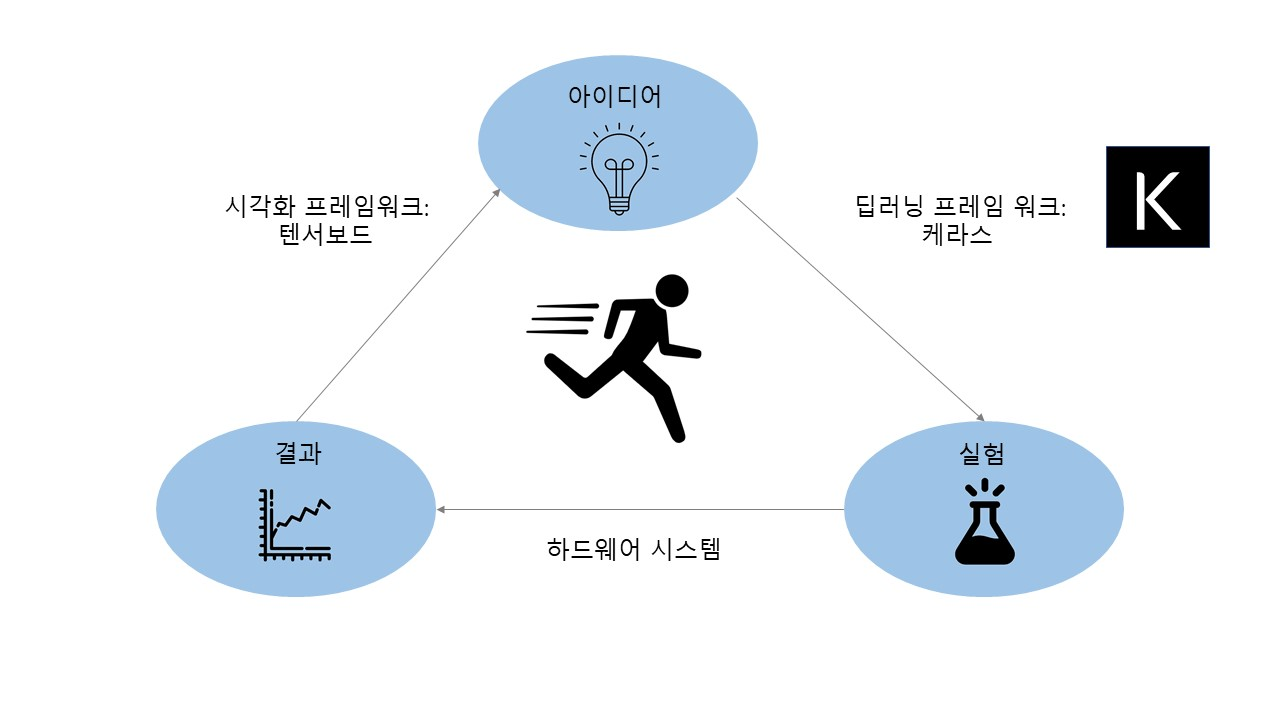

이 절에서는 텐서플로와 함께 제공되는 브라우저 기반 시각화 도구인 텐서보드를 소개합니다. 텐서플로 백엔드로 케라스를 설정한 경우에만 케라스 모델에서 사용할 수 있습니다.

텐서보드의 핵심 목적은 훈련 모델의 내부에서 일어나는 모든 것을 시각적으로 모니터링할 수 있도록 돕는 것입니다. 모델의 최종 손실 오에 더 많은 정보를 모니터링하면 모델 작동에 대한 명확한 그림을 그릴 수 있습니다. 결국 모델을 더 빠르게 개선할 수 있습니다. 텐서보드는 여러 가지 멋진 기능을 제공합니다. 모든 부라우저에서 작동합니다.

 * 훈련하는 동안 측정 짚를 시각적으로 모니터링합니다.
 * 모델 구조를 시각화합니다.
 * 활성화 출력과 그래디언트의 히스토그램을 그립니다.
 * 3D로 임데빙을 표현합니다.

간단한 예를 사용하여 이 기능들을 실습해 보죠. IMDB 감성분석 문제를 위해 1D컨브넷을 훈련하겠습니다.

이 모델은 6장 마지막 절에서 보았던 것과 비슷합니다. IMDB 어휘사전에서 빈도가 높은 2,000개 단어만 사용하겠습니다. 이렇게 하면 단어 임베딩을 시각화하기가 조금 더 쉽습니다.

In [2]:
import keras
from keras import layers
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 2000  # 특성으로 사용할 단어의 수
max_len = 500 # 사용할 텍스트의 길이(가장 빈번한 max_features개의 단어만 사용)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)
x_train = sequence.pad_sequences(x_train, maxlen = max_len)
x_test = sequence.pad_sequences(x_test, maxlen = max_len)

model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128,
                           input_length = max_len,
                           name = 'embed'))
model.add(layers.Conv1D(32,7,activation = 'relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer = 'rmsprop',
              loss='binary_crossentropy',
              metrics = ['acc'])

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
__________________________________________________

In [3]:
callbacks = [
             keras.callbacks.TensorBoard(
                 log_dir = '/content/drive/MyDrive/Classroom/케라스 창시자에게 배우는 딥러닝 연습 폴더/my_log_dir',  #로그 파일이 기록될 위치입니다.
                 histogram_freq = 1,   #1에포크마다 활성화 출력의 히스토그램을 기록합니다.
                 embeddings_freq = 1,  #1에포크마다 임베딩 데이터를 기록합니다.
             )
]

history = model.fit(x_train, y_train,
                    epochs = 20,
                    batch_size = 128,
                    validation_split = 0.2,
                    callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 93s 491ms/step - loss: 0.6763 - acc: 0.6022 - val_loss: 0.4902 - val_acc: 0.8266
Epoch 2/20
157/157 [==============================] - 75s 476ms/step - loss: 0.4456 - acc: 0.8440 - val_loss: 0.4097 - val_acc: 0.8562
Epoch 3/20
157/157 [==============================] - 75s 479ms/step - loss: 0.3609 - acc: 0.8869 - val_loss: 0.4318 - val_acc: 0.8646
Epoch 4/20
157/157 [==============================] - 76s 483ms/step - loss: 0.3062 - acc: 0.9073 - val_loss: 0.7680 - val_acc: 0.8306
Epoch 5/20
157/157 [==============================] - 81s 517ms/step - loss: 0.2962 - acc: 0.9224 - val_loss: 0.5550 - val_acc: 0.8696
Epoch 6/20
157/157 [==============================] - 78s 497ms/step - loss: 0.2308 - acc: 0.9457 - val_loss: 0.6168 - val_acc: 0.8652
Epoch 7/20
157/157 [==============================] - 78s 496ms/step - loss: 0.2081 - acc: 0.9585 - val_loss: 0.7934 - val_acc: 0.8560
Epoch 8/20
157/157 [==============================] - 7

이제 명령행에서 콜백이 사용하는 로그 디렉터리를 지정하여 텐서보드 서버를 실행합니다. 텐서플로를 설치했다면(예를 들어 pip명령으로 설치했다면) 텐서보드 유틸리티는 자동으로 설치되었을 것입니다.

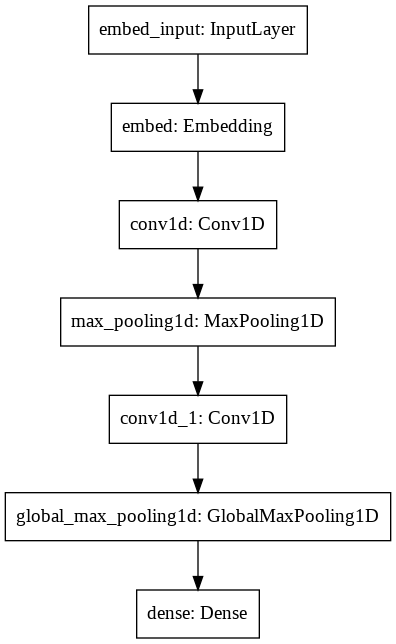

In [6]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file = 'model.png')

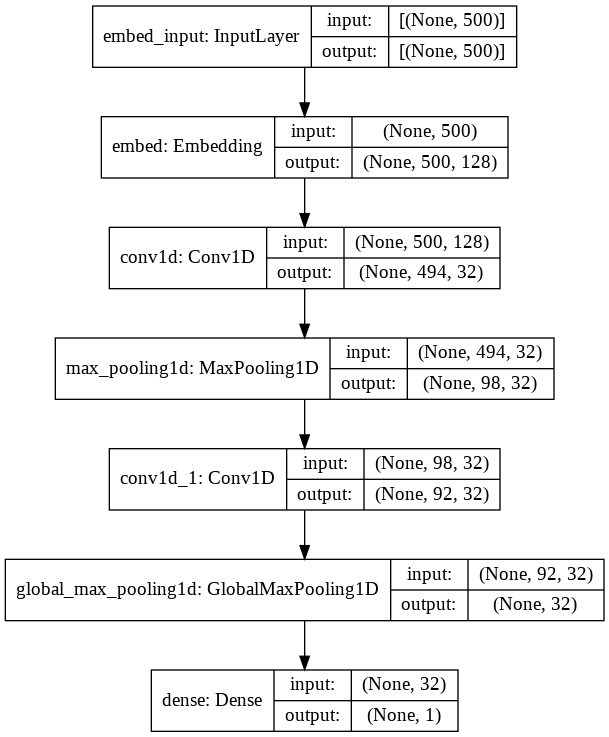

In [7]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes = True, to_file = 'model.png')